v2.1 - incorporates volatility, if delta is high: use bollinger; else: use ma

/var/folders/b9/l7b2jvjs3l1b62b471c8jm7h0000gn/T/ipykernel_20341/3513509864.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, progress=False)


------------------------------------------
 STRATEGY REPORT - BA
------------------------------------------
 Sharpe Ratio:        0.639
 Max Drawdown:        -47.12%
 CAGR:                11.05%
 Final Equity:        3.16x
------------------------------------------
 Hold Equity:         1.95x


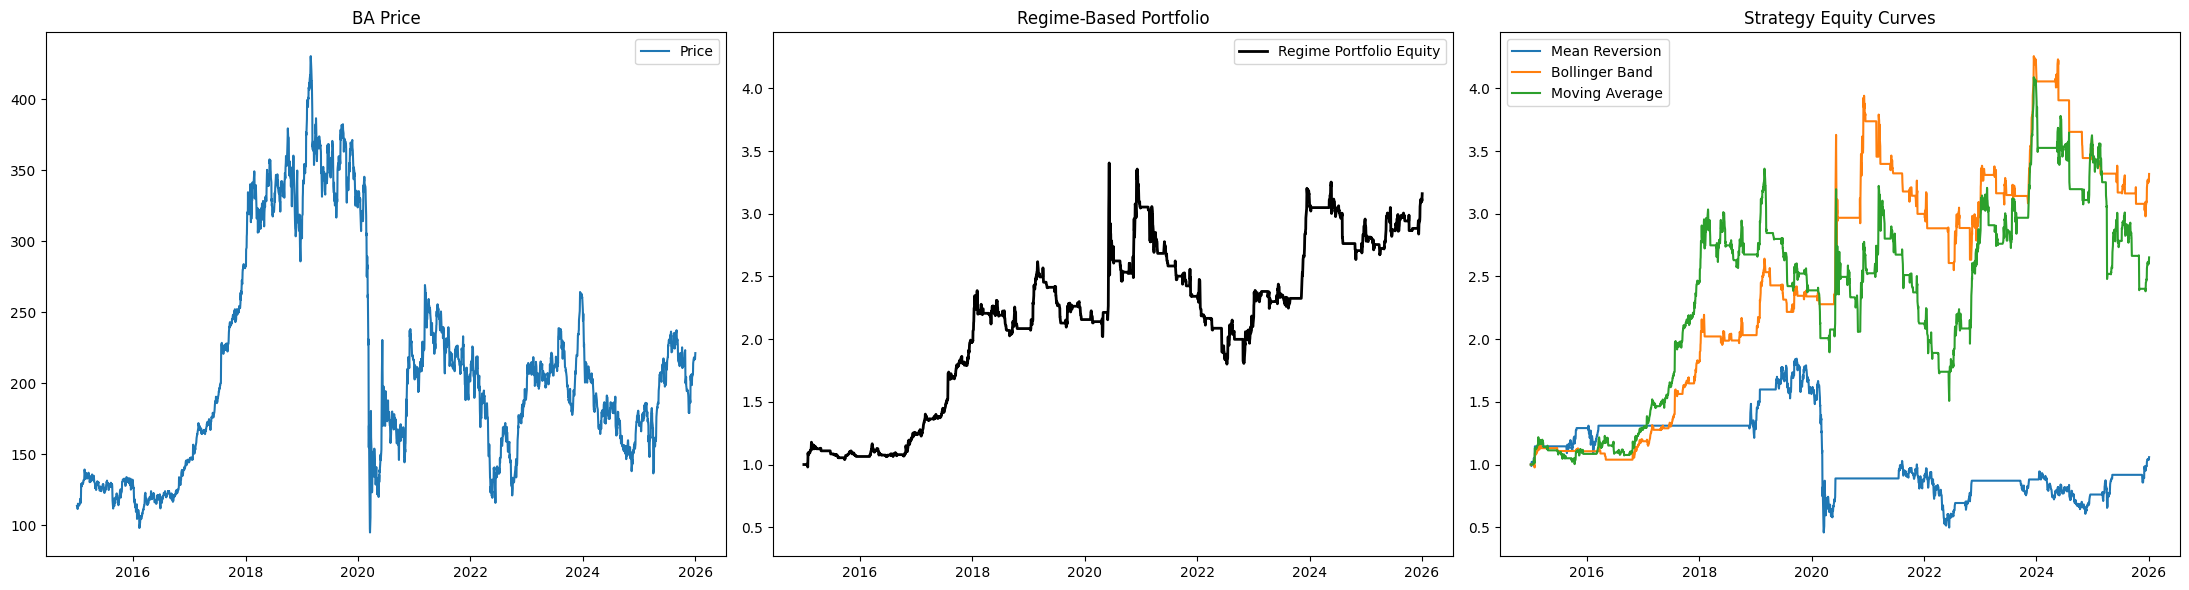

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# ---------------- PARAMETERS ----------------
ticker = "BA"
start_date = "2015-01-01"

# RSI
rsi_len = 14
rsi_buy = 30
rsi_sell = 70

# Bollinger
bb_length = 16
bb_mult = 2

# MA
ma_fast = 10
ma_slow = 30

# volatility regime
delta_ma_window = 30
high_delta = 1.2

# ---------------- DATA ----------------
df = yf.download(ticker, start=start_date, progress=False)
df['PRICE'] = df['Close']

# ---------------- INDICATORS ----------------
# RSI
delta = df['PRICE'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.ewm(alpha=1/rsi_len, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/rsi_len, adjust=False).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger
df['mid'] = df['PRICE'].rolling(bb_length, min_periods=1).mean()
df['std'] = df['PRICE'].rolling(bb_length, min_periods=1).std()
df['upper'] = df['mid'] + bb_mult * df['std']
df['lower'] = df['mid'] - bb_mult * df['std']

# Moving averages
df['MA_fast'] = df['PRICE'].rolling(ma_fast, min_periods=1).mean()
df['MA_slow'] = df['PRICE'].rolling(ma_slow, min_periods=1).mean()

# ---------------- STRATEGY RETURNS ----------------
# Reversion
df['signal_rsi'] = np.where(df['RSI'] < rsi_buy, 1,
                    np.where(df['RSI'] > rsi_sell, 0, np.nan))
df['signal_rsi'] = df['signal_rsi'].ffill().fillna(0)
df['pos_rsi'] = df['signal_rsi'].shift(1).fillna(0)
df['ret_rsi'] = df['pos_rsi'] * df['PRICE'].pct_change().fillna(0)
df['equity_rsi'] = (1 + df['ret_rsi']).cumprod()

# Bollinger band
df['signal_bb'] = np.where(df['PRICE'] > df['upper'], 1,
                    np.where(df['PRICE'] < df['mid'], 0, np.nan))
df['signal_bb'] = df['signal_bb'].ffill().fillna(0)
df['pos_bb'] = df['signal_bb'].shift(1).fillna(0)
df['ret_bb'] = df['pos_bb'] * df['PRICE'].pct_change().fillna(0)
df['equity_bb'] = (1 + df['ret_bb']).cumprod()

# MA crossover trend
df['signal_ma'] = np.where(df['MA_fast'] > df['MA_slow'], 1, 0)
df['pos_ma'] = df['signal_ma'].shift(1).fillna(0)
df['ret_ma'] = df['pos_ma'] * df['PRICE'].pct_change().fillna(0)
df['equity_ma'] = (1 + df['ret_ma']).cumprod()

# hold benchmark
df['ret_hold'] = df['PRICE'].pct_change().fillna(0)
df['equity_hold'] = (1 + df['ret_hold']).cumprod()

# ---------------- VOLATILITY ----------------
df['delta'] = df['PRICE'].diff()
df['abs_delta'] = df['delta'].abs()
df['delta_ma'] = df['abs_delta'].rolling(delta_ma_window, min_periods=1).mean()

df['regime'] = np.where(df['abs_delta'] > (high_delta * df['delta_ma']), 'bb', 'ma')

# ---------------- PORTFOLIO ----------------
df['ret_regime'] = np.where(df['regime'] == 'bb', df['ret_bb'], df['ret_ma'])

df['portfolio_equity'] = (1 + df['ret_regime']).cumprod()

# ---------------- REPORT ----------------
def sharpe(returns, periods=252):
    if returns.std() == 0:
        return 0.0
    return (returns.mean() * periods) / (returns.std() * np.sqrt(periods))

def max_drawdown(equity):
    roll_max = equity.cummax()
    dd = (equity - roll_max) / roll_max
    return dd.min()

total_returns = df['ret_regime'].fillna(0)
combined_sharpe = sharpe(total_returns)
combined_mdd = max_drawdown(df['portfolio_equity'])
combined_cagr = df['portfolio_equity'].iloc[-1] ** (252/len(df)) - 1

print("------------------------------------------")
print(f" STRATEGY REPORT - {ticker}")
print("------------------------------------------")
print(f" Sharpe Ratio:        {combined_sharpe:.3f}")
print(f" Max Drawdown:        {combined_mdd:.2%}")
print(f" CAGR:                {combined_cagr:.2%}")
print(f" Final Equity:        {df['portfolio_equity'].iloc[-1]:.2f}x")
print("------------------------------------------")
print(f" Hold Equity:         {df['equity_hold'].iloc[-1]:.2f}x")

# ---------------- PLOTTING (3 panels) ----------------
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

axes[2].sharey(axes[1])

# Ticker price
axes[0].plot(df['PRICE'], label='Price')
axes[0].set_title(f'{ticker} Price')
axes[0].legend()

# Portfolio curve
axes[1].plot(df['portfolio_equity'], label='Regime Portfolio Equity', linewidth=2, color='black')
axes[1].set_title('Regime-Based Portfolio')
axes[1].legend()

# Strategy equity curves
axes[2].plot(df['equity_rsi'], label='Mean Reversion')
axes[2].plot(df['equity_bb'], label='Bollinger Band')
axes[2].plot(df['equity_ma'], label='Moving Average')
axes[2].set_title('Strategy Equity Curves')
axes[2].legend()

plt.tight_layout()
plt.show()